# Multidimensional Poverty Index (MPI) Clustering Analysis

## PhD-Level Rigorous Methodology for Binary Deprivation Data

---

### About This Analysis

This notebook implements a **rigorous, PhD-level methodology** for clustering household-level Multidimensional Poverty Index (MPI) data. Unlike naive approaches that apply K-Means to binary data, this analysis recognizes the fundamental mathematical constraints of binary deprivation indicators.

**Key Insight:** Standard clustering algorithms (K-Means, Gaussian Mixture Models) assume:
- Continuous, normally distributed variables
- Euclidean geometry for distance calculations

These assumptions are **mathematically violated** when working with binary deprivation data (`X in {0,1}^{N x D}`). This notebook uses appropriate methodologies instead.

---

### Table of Contents

1. **Data Loading & Exploration**
2. **Mathematical Preprocessing & Feature Engineering**
   - Tetrachoric Correlation Analysis
   - Multiple Correspondence Analysis (MCA)
3. **Core Clustering Methodologies**
   - Methodology A: Latent Class Analysis (LCA) - Probabilistic Gold Standard
   - Methodology B: K-Modes with Jaccard Distance
   - Methodology C: Hierarchical Clustering with Jaccard Distance
4. **Model Comparison & Selection**
5. **Cluster Profiling - "The Faces of Poverty"**
   - Item Response Probabilities
   - Relative Risk Ratios
6. **Validation Framework**
   - Bootstrap Stability Analysis
   - External Validation
7. **Conclusions & Policy Implications**

---

## 1. Data Loading & Environment Setup

First, we load the necessary libraries and the MPI dataset. The dataset contains binary (0/1) deprivation indicators across multiple dimensions including:
- **Health** indicators
- **Education** indicators
- **Living Standards** indicators
- **Maqasid Syariah** indicators (unique to this dataset)

In [2]:
# =============================================================================
# IMPORTS & CONFIGURATION
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configure display
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Custom color palette for visualizations
COLORS = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']

print("Environment configured successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Environment configured successfully!
NumPy version: 2.2.6
Pandas version: 2.3.3


In [3]:
# =============================================================================
# LOAD THE MPI DATASET
# =============================================================================

import pyreadstat

# Load the SPSS file with metadata
df, meta = pyreadstat.read_sav('data/DATA MPI SPSS.sav')

print(f"Dataset Shape: {df.shape[0]:,} households x {df.shape[1]} variables")
print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")

Dataset Shape: 400 households x 22 variables

DATASET OVERVIEW


In [4]:
# =============================================================================
# DISPLAY VARIABLE METADATA
# =============================================================================

# Create a variable view similar to SPSS
variable_info = []

for col in df.columns:
    label = meta.column_names_to_labels.get(col, "") if hasattr(meta, 'column_names_to_labels') else ""
    dtype = str(df[col].dtype)
    n_unique = df[col].nunique()
    n_missing = df[col].isnull().sum()
    
    # Determine if binary
    unique_vals = df[col].dropna().unique()
    is_binary = len(unique_vals) <= 2
    
    variable_info.append({
        'Variable': col,
        'Label': label,
        'Type': dtype,
        'Unique': n_unique,
        'Missing': n_missing,
        'Binary': 'Yes' if is_binary else 'No'
    })

var_df = pd.DataFrame(variable_info)
print("Variable Metadata (first 20 variables):")
var_df.head(20)

Variable Metadata (first 20 variables):


,Variable,Label,Type,Unique,Missing,Binary
0,R,None,object,399,0,No
1,BLB,B/LB,object,2,0,Yes
2,PendapatanbulananpurataisirumahkurangdaripadaPGK,Pendapatan bulanan purata isi rumah kurang dar...,float64,2,0,Yes
3,Keadaantempattinggalusangataumulaiburuk,Keadaan tempat tinggal usang atau mulai buruk,float64,2,0,Yes
4,Lebih2ahliisirumahbilik,Lebih 2 ahli isi rumah/bilik,float64,2,0,Yes
5,Menggunakantandasselaindaripadatandaspam,Menggunakan tandas selain daripada tandas pam,float64,2,0,Yes
6,TiadakemudahanKutipanSampah,Tiada kemudahan Kutipan Sampah,float64,2,0,Yes
7,Semuaahliisirumahsamaadatidakmenggunakanpengan...,Semua ahli isi rumah sama ada tidak menggunaka...,float64,2,0,Yes
8,Isirumahtidakmampumenyewadanmemilikirumah,Isi Rumah tidak mampu menyewa da memiliki rumah,float64,2,0,Yes
9,Tidakmemilikitelefontaliantetapatautelefonbimbit,Tidak memiliki telefon talian tetap atau telef...,float64,2,0,Yes


In [5]:
# =============================================================================
# IDENTIFY BINARY DEPRIVATION INDICATORS
# =============================================================================

# Import from our custom utilities
import sys
sys.path.insert(0, '.')

from utils.binary_analysis import get_binary_columns, binarize_dataframe

# Identify binary columns automatically
binary_cols = get_binary_columns(df)

print(f"\nFound {len(binary_cols)} binary/near-binary columns:")
print("-" * 40)
for i, col in enumerate(binary_cols, 1):
    label = meta.column_names_to_labels.get(col, "")[:50] if hasattr(meta, 'column_names_to_labels') else ""
    print(f"{i:2d}. {col:<15} | {label}")


Found 21 binary/near-binary columns:
----------------------------------------
 1. BLB             | B/LB
 2. PendapatanbulananpurataisirumahkurangdaripadaPGK | Pendapatan bulanan purata isi rumah kurang daripad
 3. Keadaantempattinggalusangataumulaiburuk | Keadaan tempat tinggal usang atau mulai buruk
 4. Lebih2ahliisirumahbilik | Lebih 2 ahli isi rumah/bilik
 5. Menggunakantandasselaindaripadatandaspam | Menggunakan tandas selain daripada tandas pam
 6. TiadakemudahanKutipanSampah | Tiada kemudahan Kutipan Sampah
 7. Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian | Semua ahli isi rumah sama ada tidak menggunakan pe
 8. Isirumahtidakmampumenyewadanmemilikirumah | Isi Rumah tidak mampu menyewa da memiliki rumah
 9. Tidakmemilikitelefontaliantetapatautelefonbimbit | Tidak memiliki telefon talian tetap atau telefon b
10. Tidakdapatmengaksesinternet | Tidak dapat mengakses internet
11. TidakmendapatkemudahanawamTeknologiICT | Tidak mendapat kemudahan awam Teknologi ICT
1

In [6]:
# =============================================================================
# SELECT DEPRIVATION INDICATORS FOR ANALYSIS
# =============================================================================

# Define the core deprivation indicators based on MPI framework
# Adjust these based on your specific dataset columns

# Attempt to identify common MPI-related variables
potential_indicators = [col for col in binary_cols if col not in ['ID', 'IDNO', 'Nombor']]

# Use the identified binary columns (excluding ID-like columns)
deprivation_cols = potential_indicators[:20]  # Take first 20 for manageable analysis

print(f"Selected {len(deprivation_cols)} deprivation indicators for clustering:")
print("=" * 60)
for col in deprivation_cols:
    label = meta.column_names_to_labels.get(col, "No label")[:50] if hasattr(meta, 'column_names_to_labels') else "No label"
    print(f"  - {col}: {label}")

Selected 20 deprivation indicators for clustering:
  - BLB: B/LB
  - PendapatanbulananpurataisirumahkurangdaripadaPGK: Pendapatan bulanan purata isi rumah kurang daripad
  - Keadaantempattinggalusangataumulaiburuk: Keadaan tempat tinggal usang atau mulai buruk
  - Lebih2ahliisirumahbilik: Lebih 2 ahli isi rumah/bilik
  - Menggunakantandasselaindaripadatandaspam: Menggunakan tandas selain daripada tandas pam
  - TiadakemudahanKutipanSampah: Tiada kemudahan Kutipan Sampah
  - Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian: Semua ahli isi rumah sama ada tidak menggunakan pe
  - Isirumahtidakmampumenyewadanmemilikirumah: Isi Rumah tidak mampu menyewa da memiliki rumah
  - Tidakmemilikitelefontaliantetapatautelefonbimbit: Tidak memiliki telefon talian tetap atau telefon b
  - Tidakdapatmengaksesinternet: Tidak dapat mengakses internet
  - TidakmendapatkemudahanawamTeknologiICT: Tidak mendapat kemudahan awam Teknologi ICT
  - Semuaahliisirumahberumur1760tahunmempunyaikurang

In [7]:
# =============================================================================
# PREPARE THE ANALYSIS DATASET
# =============================================================================

# Binarize and prepare the dataset
df_binary = binarize_dataframe(df, deprivation_cols)

# Remove rows with any missing values
df_analysis = df_binary.dropna()

print(f"\nAnalysis Dataset:")
print(f"  - Original rows: {len(df):,}")
print(f"  - After removing missing: {len(df_analysis):,}")
print(f"  - Variables: {len(deprivation_cols)}")

# Display deprivation rates
print(f"\n{'='*60}")
print("DEPRIVATION RATES (% of households deprived in each indicator)")
print(f"{'='*60}")

dep_rates = df_analysis.mean().sort_values(ascending=False) * 100
for col, rate in dep_rates.items():
    bar = '|' * int(rate / 2)
    print(f"{col:<20} {rate:5.1f}% {bar}")


Analysis Dataset:
  - Original rows: 400
  - After removing missing: 400
  - Variables: 20

DEPRIVATION RATES (% of households deprived in each indicator)
Lebih2ahliisirumahbilik  89.5% ||||||||||||||||||||||||||||||||||||||||||||
TidakmendapatkemudahanawamTeknologiICT  80.2% ||||||||||||||||||||||||||||||||||||||||
PendapatanbulananpurataisirumahkurangdaripadaPGK  74.8% |||||||||||||||||||||||||||||||||||||
Keadaantempattinggalusangataumulaiburuk  52.2% ||||||||||||||||||||||||||
BLB                   50.0% |||||||||||||||||||||||||
Menggunakantandasselaindaripadatandaspam  37.2% ||||||||||||||||||
Pemeliharaanakal      25.5% ||||||||||||
Tidakdapatmengaksesinternet  25.0% ||||||||||||
TiadakemudahanKutipanSampah  20.0% ||||||||||
Pengambilanmakanankurangdaripadatiga3kalisehari  19.5% |||||||||
Pemeliharaanharta     12.0% ||||||
Pemeliharaannyawa     11.8% |||||
Isirumahtidakmampumenyewadanmemilikirumah  10.2% |||||
Kanakkanakantara616tahunyangtidakbersekolah   8.0% ||||
Pemeliharaan

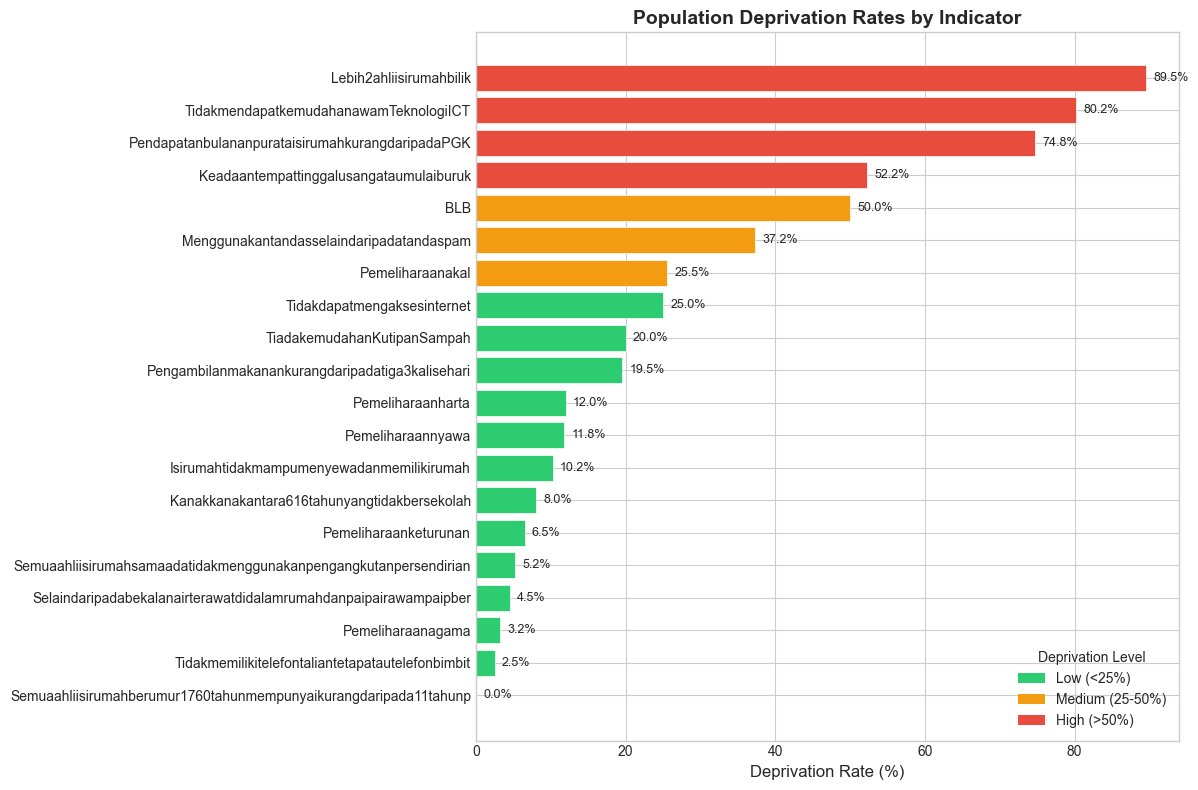


[INTERPRETATION]
This chart shows the percentage of households deprived in each indicator.
- GREEN bars: Low deprivation (<25%) - relatively fewer households affected
- ORANGE bars: Medium deprivation (25-50%) - moderate concern
- RED bars: High deprivation (>50%) - majority of households affected


In [8]:
# =============================================================================
# VISUALIZE DEPRIVATION RATES
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Sort by deprivation rate
dep_rates_sorted = df_analysis.mean().sort_values(ascending=True) * 100

# Create horizontal bar chart
colors = ['#e74c3c' if x > 50 else '#f39c12' if x > 25 else '#2ecc71' for x in dep_rates_sorted]
bars = ax.barh(range(len(dep_rates_sorted)), dep_rates_sorted, color=colors, edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(dep_rates_sorted)))
ax.set_yticklabels(dep_rates_sorted.index)
ax.set_xlabel('Deprivation Rate (%)', fontsize=12)
ax.set_title('Population Deprivation Rates by Indicator', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, dep_rates_sorted)):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Low (<25%)'),
    Patch(facecolor='#f39c12', label='Medium (25-50%)'),
    Patch(facecolor='#e74c3c', label='High (>50%)')
]
ax.legend(handles=legend_elements, loc='lower right', title='Deprivation Level')

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("This chart shows the percentage of households deprived in each indicator.")
print("- GREEN bars: Low deprivation (<25%) - relatively fewer households affected")
print("- ORANGE bars: Medium deprivation (25-50%) - moderate concern")
print("- RED bars: High deprivation (>50%) - majority of households affected")

---

## 2. Mathematical Preprocessing & Feature Engineering

Before clustering, we must address the **binary/categorical nature** of the data. Standard techniques like Pearson correlation and PCA are inappropriate for binary data.

### 2.1 Tetrachoric Correlation Analysis

**Why Tetrachoric Correlation?**

Standard Pearson correlation is **mathematically inappropriate** for binary data because:
- It assumes continuous, normally distributed variables
- It underestimates the true correlation between binary variables

**Tetrachoric correlation** estimates the Pearson correlation between two *latent continuous variables* that underlie the observed binary data. This is based on the assumption that each binary variable is a dichotomization of an underlying normally distributed variable.

**Interpretation:**
- Values close to **+1** indicate strong positive correlation (deprivations tend to occur together)
- Values close to **-1** indicate strong negative correlation (deprivations tend to be mutually exclusive)
- Values close to **0** indicate no relationship
- Correlations **> 0.9** suggest **redundant** indicators that may need to be consolidated

In [9]:
# =============================================================================
# TETRACHORIC CORRELATION MATRIX
# =============================================================================

from utils.binary_analysis import tetrachoric_correlation_matrix, identify_redundant_features

print("Computing Tetrachoric Correlation Matrix...")
print("(This may take a moment for large datasets)\n")

# Calculate tetrachoric correlation
tetra_corr = tetrachoric_correlation_matrix(df_analysis)

print("Tetrachoric Correlation Matrix:")
print("=" * 60)
print("\n[INTERPRETATION GUIDE]")
print("- Values range from -1 to +1")
print("- HIGH positive values (>0.7): Deprivations often occur TOGETHER")
print("- HIGH negative values (<-0.7): Deprivations are MUTUALLY EXCLUSIVE")
print("- Values near 0: No systematic relationship")
print("\nMatrix (first 10x10):")
tetra_corr.iloc[:10, :10].round(3)

Computing Tetrachoric Correlation Matrix...
(This may take a moment for large datasets)

Tetrachoric Correlation Matrix:

[INTERPRETATION GUIDE]
- Values range from -1 to +1
- HIGH positive values (>0.7): Deprivations often occur TOGETHER
- HIGH negative values (<-0.7): Deprivations are MUTUALLY EXCLUSIVE
- Values near 0: No systematic relationship

Matrix (first 10x10):


,BLB,PendapatanbulananpurataisirumahkurangdaripadaPGK,Keadaantempattinggalusangataumulaiburuk,Lebih2ahliisirumahbilik,Menggunakantandasselaindaripadatandaspam,TiadakemudahanKutipanSampah,Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian,Isirumahtidakmampumenyewadanmemilikirumah,Tidakmemilikitelefontaliantetapatautelefonbimbit,Tidakdapatmengaksesinternet
BLB,1.000,-0.864,-0.134,-0.927,-0.025,0.773,0.986,0.937,0.996,0.486
PendapatanbulananpurataisirumahkurangdaripadaPGK,-0.864,1.000,-0.902,0.116,0.236,0.401,-0.312,-0.988,0.400,0.895
Keadaantempattinggalusangataumulaiburuk,-0.134,-0.902,1.000,-0.998,0.124,0.769,0.176,0.988,0.988,0.763
Lebih2ahliisirumahbilik,-0.927,0.116,-0.998,1.000,0.569,-0.924,0.664,-0.856,0.068,-0.218
Menggunakantandasselaindaripadatandaspam,-0.025,0.236,0.124,0.569,1.000,0.142,0.264,0.278,0.259,0.356
TiadakemudahanKutipanSampah,0.773,0.401,0.769,-0.924,0.142,1.000,-0.637,-0.584,-0.686,-0.211
Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian,0.986,-0.312,0.176,0.664,0.264,-0.637,1.000,-0.883,-0.980,-0.428
Isirumahtidakmampumenyewadanmemilikirumah,0.937,-0.988,0.988,-0.856,0.278,-0.584,-0.883,1.000,-0.915,-0.329
Tidakmemilikitelefontaliantetapatautelefonbimbit,0.996,0.400,0.988,0.068,0.259,-0.686,-0.980,-0.915,1.000,-0.461
Tidakdapatmengaksesinternet,0.486,0.895,0.763,-0.218,0.356,-0.211,-0.428,-0.329,-0.461,1.000


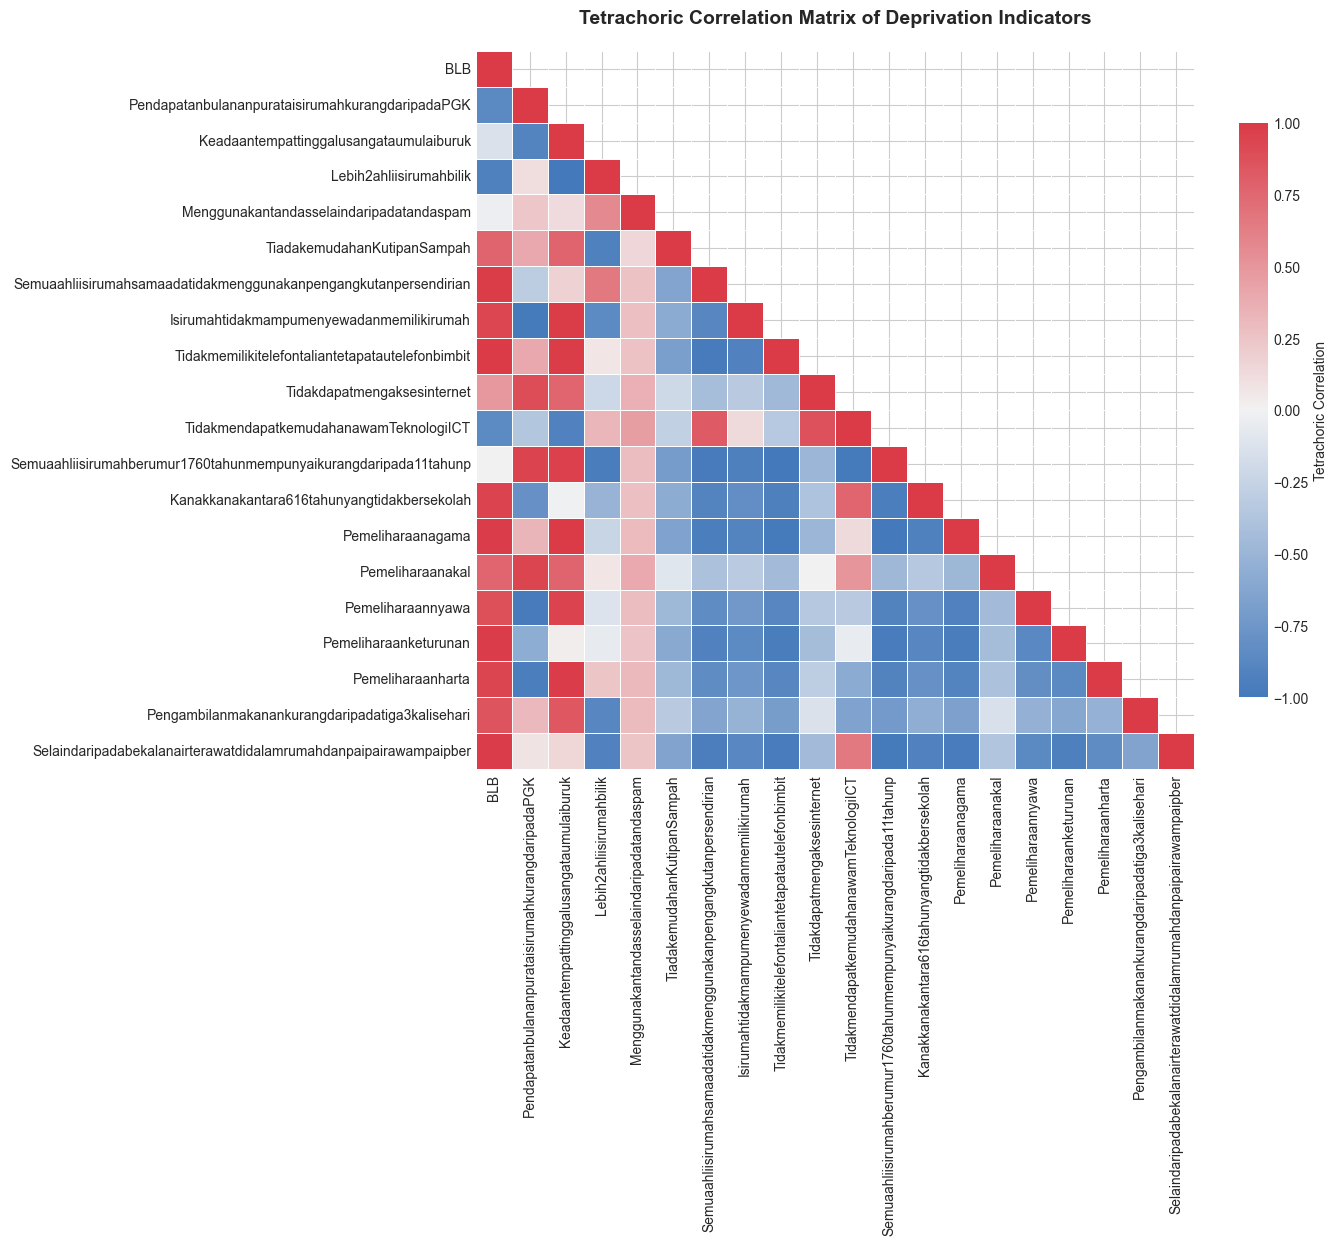


[INTERPRETATION]
- DARK RED: Strong positive correlation (deprivations co-occur)
- DARK BLUE: Strong negative correlation (mutually exclusive)
- WHITE: No correlation

Look for clusters of red cells - these indicate groups of related deprivations.


In [10]:
# =============================================================================
# VISUALIZE TETRACHORIC CORRELATION HEATMAP
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 12))

# Create heatmap
mask = np.triu(np.ones_like(tetra_corr, dtype=bool), k=1)
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(tetra_corr, 
            mask=mask,
            annot=True if len(tetra_corr) <= 12 else False,
            fmt='.2f',
            cmap=cmap,
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Tetrachoric Correlation'},
            vmin=-1, vmax=1,
            ax=ax)

ax.set_title('Tetrachoric Correlation Matrix of Deprivation Indicators', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("- DARK RED: Strong positive correlation (deprivations co-occur)")
print("- DARK BLUE: Strong negative correlation (mutually exclusive)")
print("- WHITE: No correlation")
print("\nLook for clusters of red cells - these indicate groups of related deprivations.")

In [11]:
# =============================================================================
# IDENTIFY REDUNDANT FEATURES
# =============================================================================

# Find pairs with correlation > 0.9 (potentially redundant)
redundant_pairs = identify_redundant_features(tetra_corr, threshold=0.9)

print("\nREDUNDANT FEATURE ANALYSIS (Correlation > 0.9)")
print("=" * 60)

if len(redundant_pairs) > 0:
    print("\nThe following pairs have very high correlation and may represent")
    print("the SAME underlying deprivation. Consider consolidating them:\n")
    
    for var1, var2, corr in redundant_pairs:
        print(f"  {var1} <---> {var2}")
        print(f"  Correlation: {corr:.3f}")
        print()
else:
    print("\nNo highly redundant pairs found (all correlations < 0.9).")
    print("All indicators appear to measure distinct aspects of deprivation.")

# Show high correlations (> 0.7)
high_corr_pairs = identify_redundant_features(tetra_corr, threshold=0.7)
print(f"\nNumber of pairs with correlation > 0.7: {len(high_corr_pairs)}")
print(f"Number of pairs with correlation > 0.9: {len(redundant_pairs)}")


REDUNDANT FEATURE ANALYSIS (Correlation > 0.9)

The following pairs have very high correlation and may represent
the SAME underlying deprivation. Consider consolidating them:

  BLB <---> Lebih2ahliisirumahbilik
  Correlation: -0.927

  BLB <---> Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian
  Correlation: 0.986

  BLB <---> Isirumahtidakmampumenyewadanmemilikirumah
  Correlation: 0.937

  BLB <---> Tidakmemilikitelefontaliantetapatautelefonbimbit
  Correlation: 0.996

  BLB <---> Kanakkanakantara616tahunyangtidakbersekolah
  Correlation: 0.952

  BLB <---> Pemeliharaanagama
  Correlation: 0.983

  BLB <---> Pemeliharaanketurunan
  Correlation: 0.977

  BLB <---> Pemeliharaanharta
  Correlation: 0.942

  BLB <---> Selaindaripadabekalanairterawatdidalamrumahdanpaipairawampaipber
  Correlation: 0.980

  PendapatanbulananpurataisirumahkurangdaripadaPGK <---> Keadaantempattinggalusangataumulaiburuk
  Correlation: -0.902

  PendapatanbulananpurataisirumahkurangdaripadaPG

### 2.2 Multiple Correspondence Analysis (MCA)

**Why MCA instead of PCA?**

PCA (Principal Component Analysis) assumes:
- Continuous variables
- Linear relationships
- Normally distributed data

**Multiple Correspondence Analysis (MCA)** is the appropriate dimensionality reduction technique for categorical/binary data. It:
- Projects binary data into a continuous Euclidean space
- Allows visualization of the "poverty landscape"
- Identifies which deprivation dimensions co-vary

**Key Metrics:**

| Metric | Meaning | Interpretation |
|--------|---------|----------------|
| **Eigenvalue** | Variance explained by each dimension | **Higher = more important** dimension |
| **Inertia** | Total variance in the data | **Higher = more spread** in the data |
| **Explained Inertia %** | % of total variance explained | **Higher = better** dimension captures structure |

In [12]:
# =============================================================================
# MULTIPLE CORRESPONDENCE ANALYSIS (MCA)
# =============================================================================

from utils.binary_analysis import perform_mca

print("Performing Multiple Correspondence Analysis (MCA)...\n")

# Perform MCA
mca_results = perform_mca(df_analysis, n_components=5)

print("MCA RESULTS")
print("=" * 60)
print(f"Total Inertia: {mca_results['total_inertia']:.4f}")
print(f"Number of Components Extracted: {mca_results['n_components']}")

print("\nExplained Inertia by Component:")
print("-" * 40)

cumulative = 0
for i, (eig, inertia) in enumerate(zip(mca_results['eigenvalues'], mca_results['explained_inertia'])):
    cumulative += inertia * 100
    bar = '|' * int(inertia * 100)
    print(f"Dim {i+1}: {inertia*100:5.2f}% (Cumulative: {cumulative:5.2f}%) {bar}")

print("\n[INTERPRETATION]")
print("- Each dimension captures a different 'axis' of poverty variation")
print("- Higher explained inertia = more important dimension")
print("- First 2-3 dimensions often capture the main poverty patterns")

Performing Multiple Correspondence Analysis (MCA)...

MCA RESULTS
Total Inertia: 50776.6384
Number of Components Extracted: 5

Explained Inertia by Component:
----------------------------------------
Dim 1: 15.95% (Cumulative: 15.95%) |||||||||||||||
Dim 2: 11.89% (Cumulative: 27.85%) |||||||||||
Dim 3:  9.50% (Cumulative: 37.34%) |||||||||
Dim 4:  7.45% (Cumulative: 44.79%) |||||||
Dim 5:  7.08% (Cumulative: 51.87%) |||||||

[INTERPRETATION]
- Each dimension captures a different 'axis' of poverty variation
- Higher explained inertia = more important dimension
- First 2-3 dimensions often capture the main poverty patterns


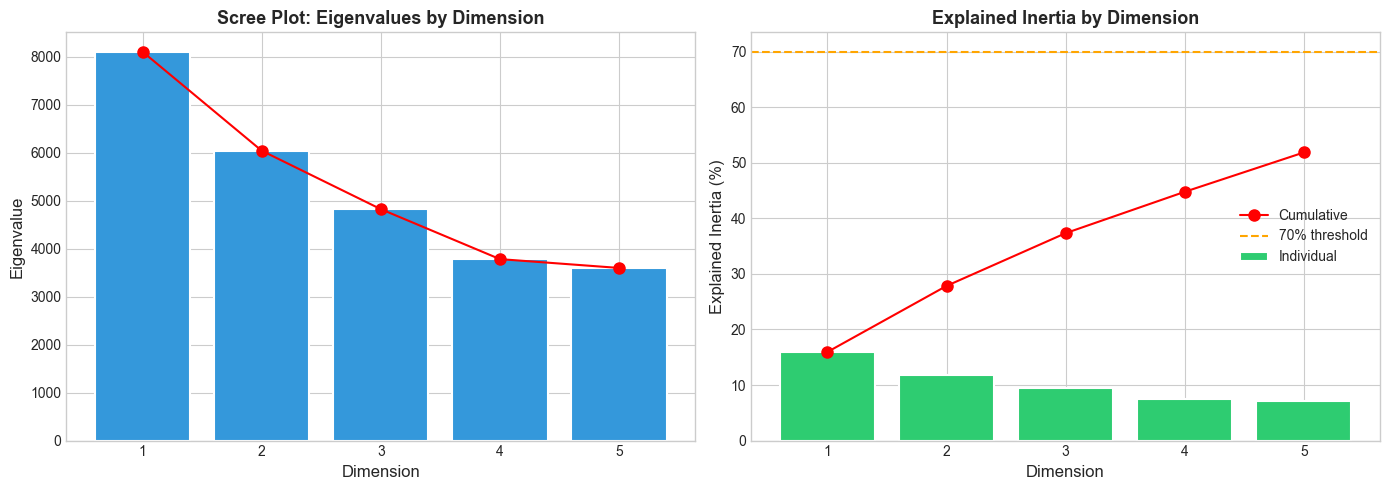


[INTERPRETATION]
SCREE PLOT (Left):
- Look for the 'elbow' where eigenvalues drop sharply
- Dimensions before the elbow capture meaningful structure

CUMULATIVE INERTIA (Right):
- Orange line shows 70% threshold (common benchmark)
- The number of dimensions needed to reach 70% indicates data complexity


In [13]:
# =============================================================================
# VISUALIZE MCA - SCREE PLOT
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot (Eigenvalues)
ax1 = axes[0]
dims = range(1, len(mca_results['eigenvalues']) + 1)
ax1.bar(dims, mca_results['eigenvalues'], color='#3498db', edgecolor='white', linewidth=1.5)
ax1.plot(dims, mca_results['eigenvalues'], 'ro-', markersize=8)
ax1.set_xlabel('Dimension', fontsize=12)
ax1.set_ylabel('Eigenvalue', fontsize=12)
ax1.set_title('Scree Plot: Eigenvalues by Dimension', fontsize=13, fontweight='bold')
ax1.set_xticks(dims)

# Cumulative Explained Inertia
ax2 = axes[1]
cumulative_inertia = np.cumsum(mca_results['explained_inertia']) * 100
ax2.bar(dims, mca_results['explained_inertia'] * 100, color='#2ecc71', edgecolor='white', linewidth=1.5, label='Individual')
ax2.plot(dims, cumulative_inertia, 'ro-', markersize=8, label='Cumulative')
ax2.axhline(y=70, color='orange', linestyle='--', label='70% threshold')
ax2.set_xlabel('Dimension', fontsize=12)
ax2.set_ylabel('Explained Inertia (%)', fontsize=12)
ax2.set_title('Explained Inertia by Dimension', fontsize=13, fontweight='bold')
ax2.set_xticks(dims)
ax2.legend(loc='right')

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("SCREE PLOT (Left):")
print("- Look for the 'elbow' where eigenvalues drop sharply")
print("- Dimensions before the elbow capture meaningful structure")
print("\nCUMULATIVE INERTIA (Right):")
print("- Orange line shows 70% threshold (common benchmark)")
print("- The number of dimensions needed to reach 70% indicates data complexity")

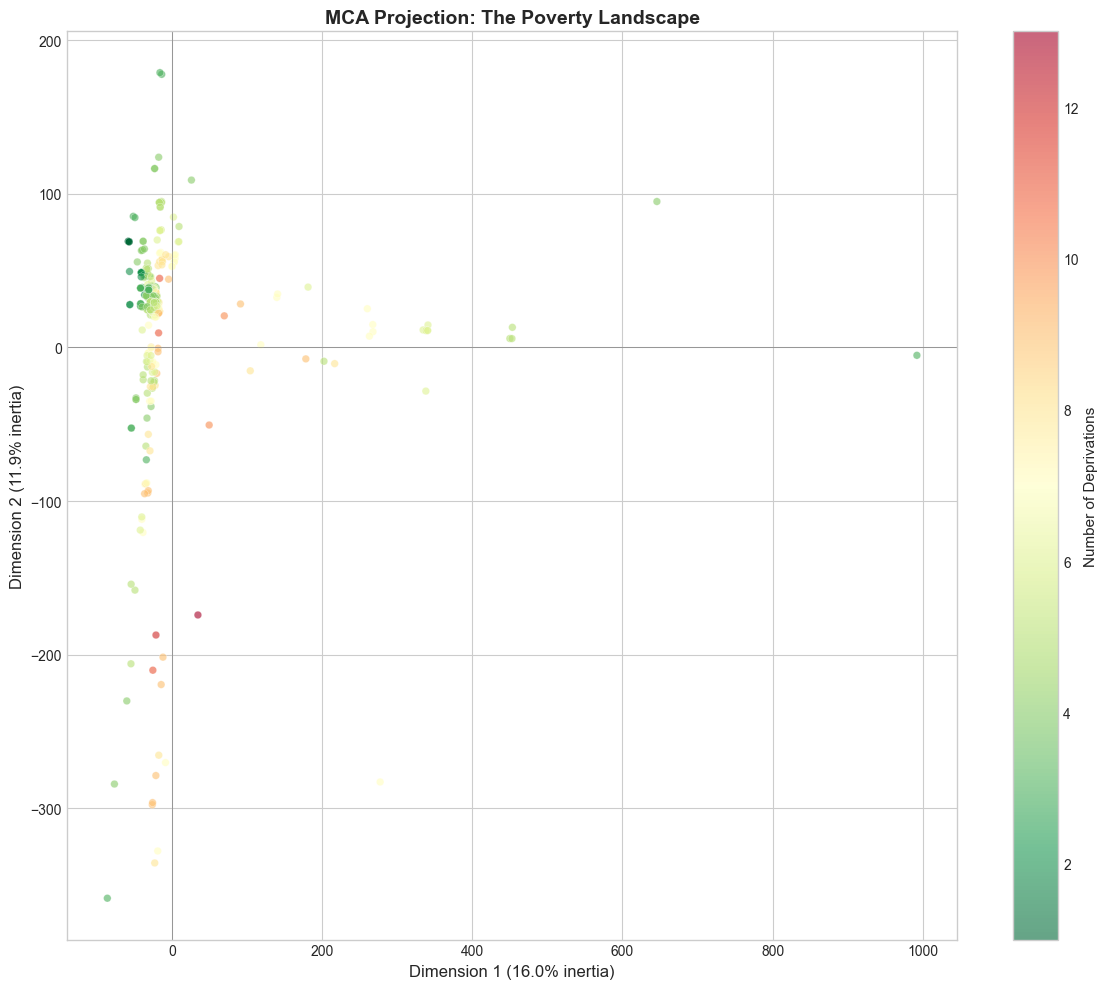


[INTERPRETATION]
This 2D plot shows each household positioned by its deprivation pattern.
- Each point represents one household
- Color indicates total number of deprivations (RED = more deprived)
- Households close together have SIMILAR deprivation patterns
- Clusters of points suggest natural groupings of poverty types


In [14]:
# =============================================================================
# VISUALIZE MCA - HOUSEHOLD PROJECTION (2D POVERTY LANDSCAPE)
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get row coordinates (household positions in MCA space)
coords = mca_results['coordinates']

# Calculate deprivation count for each household (for coloring)
dep_count = df_analysis.sum(axis=1)

# Scatter plot
scatter = ax.scatter(coords['Dim1'], coords['Dim2'], 
                     c=dep_count, cmap='RdYlGn_r', 
                     alpha=0.6, s=30, edgecolors='white', linewidth=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Deprivations', fontsize=11)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

ax.set_xlabel(f'Dimension 1 ({mca_results["explained_inertia"][0]*100:.1f}% inertia)', fontsize=12)
ax.set_ylabel(f'Dimension 2 ({mca_results["explained_inertia"][1]*100:.1f}% inertia)', fontsize=12)
ax.set_title('MCA Projection: The Poverty Landscape', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("This 2D plot shows each household positioned by its deprivation pattern.")
print("- Each point represents one household")
print("- Color indicates total number of deprivations (RED = more deprived)")
print("- Households close together have SIMILAR deprivation patterns")
print("- Clusters of points suggest natural groupings of poverty types")

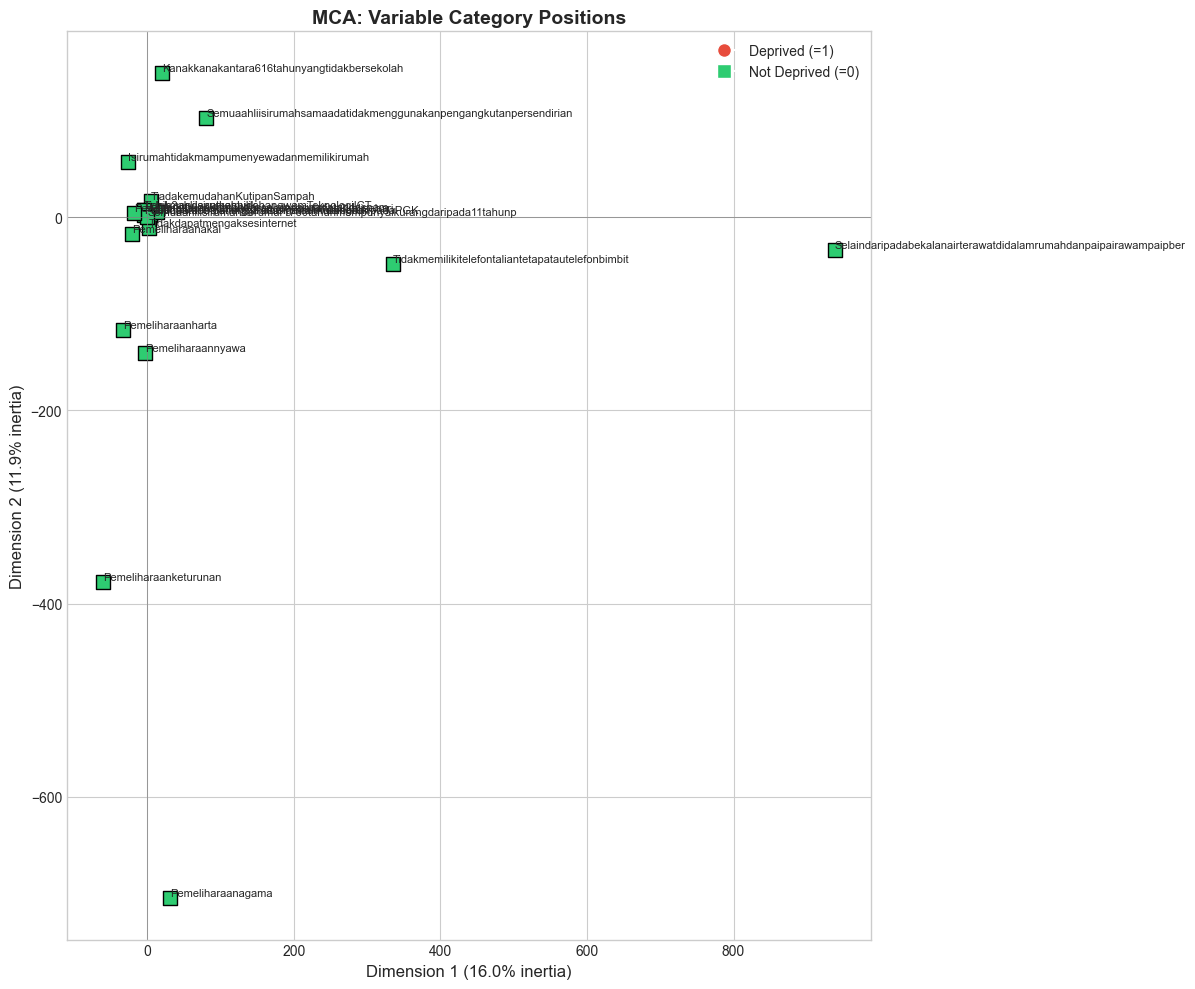


[INTERPRETATION]
This plot shows how each indicator category positions in the MCA space.
- RED circles: 'Deprived' categories (value=1)
- GREEN squares: 'Not Deprived' categories (value=0)
- Variables close together tend to co-occur in households
- Look for clusters of RED points - these are co-occurring deprivations


In [15]:
# =============================================================================
# VISUALIZE MCA - VARIABLE CONTRIBUTIONS
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get column coordinates (variable positions)
col_coords = mca_results['column_coordinates']

# Plot variable positions
for idx, row in col_coords.iterrows():
    # Determine color based on whether it's a '0' or '1' category
    if '_1' in str(idx) or str(idx).endswith('_1.0'):
        color = '#e74c3c'  # Red for deprived (1)
        marker = 'o'
    else:
        color = '#2ecc71'  # Green for not deprived (0)
        marker = 's'
    
    ax.scatter(row['Dim1'], row['Dim2'], c=color, s=100, marker=marker, edgecolors='black', linewidth=1)
    ax.annotate(idx, (row['Dim1'], row['Dim2']), fontsize=8, ha='left', va='bottom')

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

ax.set_xlabel(f'Dimension 1 ({mca_results["explained_inertia"][0]*100:.1f}% inertia)', fontsize=12)
ax.set_ylabel(f'Dimension 2 ({mca_results["explained_inertia"][1]*100:.1f}% inertia)', fontsize=12)
ax.set_title('MCA: Variable Category Positions', fontsize=14, fontweight='bold')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='Deprived (=1)'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#2ecc71', markersize=10, label='Not Deprived (=0)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("This plot shows how each indicator category positions in the MCA space.")
print("- RED circles: 'Deprived' categories (value=1)")
print("- GREEN squares: 'Not Deprived' categories (value=0)")
print("- Variables close together tend to co-occur in households")
print("- Look for clusters of RED points - these are co-occurring deprivations")

---

## 3. Core Clustering Methodologies

We now apply a **comparative experimental framework** using three rigorous methodologies appropriate for binary data:

| Methodology | Type | Key Assumption | Best For |
|-------------|------|----------------|----------|
| **Latent Class Analysis (LCA)** | Probabilistic | Conditional independence given class | Complex categorical patterns |
| **K-Modes** | Distance-based | Jaccard distance for binary similarity | Clear binary groupings |
| **Hierarchical (Jaccard)** | Distance-based | Asymmetric binary similarity | Exploring hierarchical structure |

### 3.1 Latent Class Analysis (LCA) - The Probabilistic Gold Standard

**Why LCA is preferred for survey data:**

LCA assumes there are $K$ latent (hidden) classes of households, and the observed deprivations are **independent conditional on the latent class**.

**The Model:**

$$P(\mathbf{x}_n) = \sum_{k=1}^{K} P(C_k) \prod_{d=1}^{D} P(x_{nd} | C_k)$$

Where:
- $P(C_k)$ is the **prior probability** of belonging to cluster $k$ (cluster size)
- $P(x_{nd} | C_k)$ is the **item response probability** - probability of being deprived in dimension $d$ given membership in cluster $k$

**Model Selection Criteria:**

| Criterion | Formula | Interpretation |
|-----------|---------|----------------|
| **BIC** | $-2 \ln(L) + k \ln(n)$ | **Lower is better** - penalizes complexity more |
| **AIC** | $-2 \ln(L) + 2k$ | **Lower is better** - less penalty for complexity |
| **Entropy** | Classification certainty | **Higher is better** (closer to 1.0) |

In [16]:
# =============================================================================
# LATENT CLASS ANALYSIS - MODEL SELECTION
# =============================================================================

from models.latent_class import LatentClassModel

print("LATENT CLASS ANALYSIS (LCA) - Model Selection")
print("=" * 60)
print("\nFitting LCA models for K=2 to K=8 classes...\n")

# Prepare data
X = df_analysis.values

# Store results for each K
lca_results = []

for k in range(2, 9):
    print(f"Fitting K={k} classes...", end=" ")
    
    model = LatentClassModel()
    model.set_params(n_classes=k, max_iter=100, n_init=5, random_state=42)
    labels = model.fit_predict(X)
    
    stats = model.get_model_fit_statistics()
    
    lca_results.append({
        'K': k,
        'Log-Likelihood': stats['log_likelihood'],
        'BIC': stats['bic'],
        'AIC': stats['aic'],
        'Entropy': stats['entropy'],
        'N_Parameters': stats['n_parameters'],
        'model': model,
        'labels': labels
    })
    
    print(f"BIC={stats['bic']:.1f}, Entropy={stats['entropy']:.3f}")

# Create comparison table
lca_comparison = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model', 'labels']} for r in lca_results])

print("\n" + "=" * 60)
print("MODEL COMPARISON TABLE")
print("=" * 60)
lca_comparison

LATENT CLASS ANALYSIS (LCA) - Model Selection

Fitting LCA models for K=2 to K=8 classes...

Fitting K=2 classes... BIC=6328.0, Entropy=0.955
Fitting K=3 classes... BIC=6351.9, Entropy=0.693
Fitting K=4 classes... BIC=6415.2, Entropy=0.757
Fitting K=5 classes... BIC=6489.2, Entropy=0.758
Fitting K=6 classes... BIC=6576.4, Entropy=0.799
Fitting K=7 classes... BIC=6675.5, Entropy=0.776
Fitting K=8 classes... BIC=6769.6, Entropy=0.850

MODEL COMPARISON TABLE


,K,Log-Likelihood,BIC,AIC,Entropy,N_Parameters
0,2,-3041.181323,6328.012692,6164.362646,0.955314,41
1,3,-2990.213115,6351.897031,6104.426229,0.692762,62
2,4,-2958.937855,6415.167268,6083.875711,0.756994,83
3,5,-2933.060323,6489.232959,6074.120646,0.758167,104
4,6,-2913.716972,6576.367012,6077.433943,0.799266,125
5,7,-2900.386096,6675.526015,6092.772191,0.776063,146
6,8,-2884.527755,6769.630089,6103.055510,0.849712,167


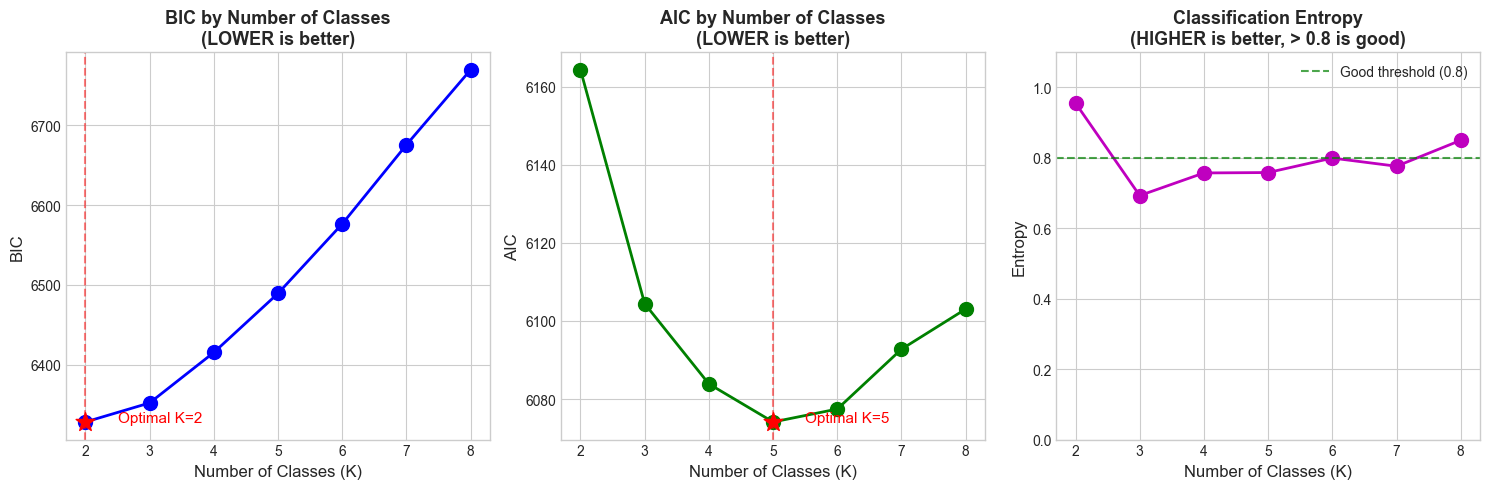


[INTERPRETATION]
- BIC suggests K=2 classes (LOWER BIC = better fit with parsimony)
- AIC suggests K=5 classes (LOWER AIC = better fit, less penalty)
- Entropy > 0.8 indicates good classification certainty

BIC is generally preferred as it penalizes model complexity more strongly.


In [17]:
# =============================================================================
# VISUALIZE LCA MODEL SELECTION CRITERIA
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# BIC Plot
ax1 = axes[0]
ax1.plot(lca_comparison['K'], lca_comparison['BIC'], 'bo-', markersize=10, linewidth=2)
best_bic_k = lca_comparison.loc[lca_comparison['BIC'].idxmin(), 'K']
best_bic = lca_comparison['BIC'].min()
ax1.scatter([best_bic_k], [best_bic], color='red', s=200, zorder=5, marker='*')
ax1.axvline(x=best_bic_k, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Number of Classes (K)', fontsize=12)
ax1.set_ylabel('BIC', fontsize=12)
ax1.set_title('BIC by Number of Classes\n(LOWER is better)', fontsize=13, fontweight='bold')
ax1.annotate(f'Optimal K={best_bic_k}', xy=(best_bic_k, best_bic), 
             xytext=(best_bic_k+0.5, best_bic), fontsize=11, color='red')

# AIC Plot
ax2 = axes[1]
ax2.plot(lca_comparison['K'], lca_comparison['AIC'], 'go-', markersize=10, linewidth=2)
best_aic_k = lca_comparison.loc[lca_comparison['AIC'].idxmin(), 'K']
best_aic = lca_comparison['AIC'].min()
ax2.scatter([best_aic_k], [best_aic], color='red', s=200, zorder=5, marker='*')
ax2.axvline(x=best_aic_k, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Classes (K)', fontsize=12)
ax2.set_ylabel('AIC', fontsize=12)
ax2.set_title('AIC by Number of Classes\n(LOWER is better)', fontsize=13, fontweight='bold')
ax2.annotate(f'Optimal K={best_aic_k}', xy=(best_aic_k, best_aic), 
             xytext=(best_aic_k+0.5, best_aic), fontsize=11, color='red')

# Entropy Plot
ax3 = axes[2]
ax3.plot(lca_comparison['K'], lca_comparison['Entropy'], 'mo-', markersize=10, linewidth=2)
ax3.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Good threshold (0.8)')
ax3.set_xlabel('Number of Classes (K)', fontsize=12)
ax3.set_ylabel('Entropy', fontsize=12)
ax3.set_title('Classification Entropy\n(HIGHER is better, > 0.8 is good)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print(f"- BIC suggests K={best_bic_k} classes (LOWER BIC = better fit with parsimony)")
print(f"- AIC suggests K={best_aic_k} classes (LOWER AIC = better fit, less penalty)")
print("- Entropy > 0.8 indicates good classification certainty")
print("\nBIC is generally preferred as it penalizes model complexity more strongly.")

In [18]:
# =============================================================================
# SELECT OPTIMAL LCA MODEL
# =============================================================================

# Select based on BIC
optimal_idx = lca_comparison['BIC'].idxmin()
optimal_k = lca_comparison.loc[optimal_idx, 'K']

print(f"OPTIMAL LCA MODEL: K = {optimal_k} classes")
print("=" * 60)

# Get the optimal model
optimal_lca = lca_results[optimal_idx]['model']
lca_labels = lca_results[optimal_idx]['labels']

# Get class probabilities (cluster sizes)
class_probs = optimal_lca.get_class_probabilities()

print("\nClass Membership Probabilities (Cluster Sizes):")
print("-" * 40)
for i, prob in enumerate(class_probs):
    n_members = np.sum(lca_labels == i)
    bar = '|' * int(prob * 50)
    print(f"Class {i}: {prob*100:5.1f}% ({n_members:,} households) {bar}")

OPTIMAL LCA MODEL: K = 2 classes

Class Membership Probabilities (Cluster Sizes):
----------------------------------------
Class 0:  89.5% (356 households) ||||||||||||||||||||||||||||||||||||||||||||
Class 1:  10.5% (44 households) |||||


### 3.2 K-Modes with Jaccard Distance

K-Modes is the categorical analogue of K-Means. Instead of means, it uses **modes** (most frequent values), and instead of Euclidean distance, it uses **Jaccard Distance**.

**Why Jaccard Distance for Poverty Data?**

$$D_{Jaccard}(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}$$

**Key Insight:**
- Two households both **LACKING** a deprivation (0-0 match) is **less informative**
- Two households both **SHARING** a deprivation (1-1 match) is **more informative**
- Jaccard handles this asymmetry; Euclidean distance does not

**Interpretation:**
- Jaccard Distance = 0: Identical deprivation patterns
- Jaccard Distance = 1: Completely different deprivation patterns

In [19]:
# =============================================================================
# K-MODES CLUSTERING WITH JACCARD DISTANCE
# =============================================================================

from models.kmodes import KModesModel

print("K-MODES CLUSTERING (Jaccard Distance)")
print("=" * 60)

# Use same K as LCA for comparison
kmodes_model = KModesModel()
kmodes_model.set_params(
    n_clusters=optimal_k,
    distance_metric='jaccard',
    init_method='cao',  # Cao initialization maximizes diversity
    max_iter=100,
    n_init=10,
    random_state=42
)

print(f"Fitting K-Modes with K={optimal_k} clusters...")
kmodes_labels = kmodes_model.fit_predict(X)

print(f"\nFinal Cost (Total Jaccard Distance): {kmodes_model.final_cost_:.4f}")
print("(Lower cost indicates better clustering)")

# Cluster sizes
print("\nCluster Sizes:")
print("-" * 40)
for i in range(optimal_k):
    n_members = np.sum(kmodes_labels == i)
    pct = n_members / len(kmodes_labels) * 100
    bar = '|' * int(pct / 2)
    print(f"Cluster {i}: {n_members:,} households ({pct:.1f}%) {bar}")

K-MODES CLUSTERING (Jaccard Distance)
Fitting K-Modes with K=2 clusters...

Final Cost (Total Jaccard Distance): 171.2573
(Lower cost indicates better clustering)

Cluster Sizes:
----------------------------------------
Cluster 0: 221 households (55.2%) |||||||||||||||||||||||||||
Cluster 1: 179 households (44.8%) ||||||||||||||||||||||


### 3.3 Hierarchical Clustering with Jaccard Distance

Hierarchical clustering builds a tree (dendrogram) of nested clusters. Using **Jaccard distance** ensures appropriate handling of binary asymmetry.

**Linkage Methods:**
- **Average**: Uses average distance between all pairs (balanced approach)
- **Complete**: Uses maximum distance (tends to create compact clusters)
- **Single**: Uses minimum distance (can create elongated clusters)

In [20]:
# =============================================================================
# HIERARCHICAL CLUSTERING WITH JACCARD DISTANCE
# =============================================================================

from models.kmodes import HierarchicalJaccardModel

print("HIERARCHICAL CLUSTERING (Jaccard Distance)")
print("=" * 60)

hier_model = HierarchicalJaccardModel()
hier_model.set_params(
    n_clusters=optimal_k,
    linkage='average',
    distance_metric='jaccard'
)

print(f"Fitting Hierarchical Clustering with K={optimal_k} clusters...")
hier_labels = hier_model.fit_predict(X)

# Cluster sizes
print("\nCluster Sizes:")
print("-" * 40)
for i in range(optimal_k):
    n_members = np.sum(hier_labels == i)
    pct = n_members / len(hier_labels) * 100
    bar = '|' * int(pct / 2)
    print(f"Cluster {i}: {n_members:,} households ({pct:.1f}%) {bar}")

HIERARCHICAL CLUSTERING (Jaccard Distance)
Fitting Hierarchical Clustering with K=2 clusters...

Cluster Sizes:
----------------------------------------
Cluster 0: 399 households (99.8%) |||||||||||||||||||||||||||||||||||||||||||||||||
Cluster 1: 1 households (0.2%) 


---

## 4. Model Comparison & Selection

We now compare the three clustering methodologies to assess their agreement and select the best approach.

In [21]:
# =============================================================================
# COMPARE CLUSTERING RESULTS
# =============================================================================

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("CLUSTERING METHOD COMPARISON")
print("=" * 60)

# Calculate agreement between methods
ari_lca_kmodes = adjusted_rand_score(lca_labels, kmodes_labels)
ari_lca_hier = adjusted_rand_score(lca_labels, hier_labels)
ari_kmodes_hier = adjusted_rand_score(kmodes_labels, hier_labels)

nmi_lca_kmodes = normalized_mutual_info_score(lca_labels, kmodes_labels)
nmi_lca_hier = normalized_mutual_info_score(lca_labels, hier_labels)
nmi_kmodes_hier = normalized_mutual_info_score(kmodes_labels, hier_labels)

print("\nAdjusted Rand Index (ARI) between methods:")
print("-" * 40)
print(f"LCA vs K-Modes:       {ari_lca_kmodes:.3f}")
print(f"LCA vs Hierarchical:  {ari_lca_hier:.3f}")
print(f"K-Modes vs Hierarchical: {ari_kmodes_hier:.3f}")

print("\nNormalized Mutual Information (NMI):")
print("-" * 40)
print(f"LCA vs K-Modes:       {nmi_lca_kmodes:.3f}")
print(f"LCA vs Hierarchical:  {nmi_lca_hier:.3f}")
print(f"K-Modes vs Hierarchical: {nmi_kmodes_hier:.3f}")

print("\n[INTERPRETATION]")
print("- ARI ranges from -1 to 1. ARI > 0.7 indicates strong agreement.")
print("- NMI ranges from 0 to 1. Higher values indicate more agreement.")
print("- High agreement suggests robust, reproducible cluster structure.")

CLUSTERING METHOD COMPARISON

Adjusted Rand Index (ARI) between methods:
----------------------------------------
LCA vs K-Modes:       -0.002
LCA vs Hierarchical:  -0.004
K-Modes vs Hierarchical: 0.001

Normalized Mutual Information (NMI):
----------------------------------------
LCA vs K-Modes:       0.000
LCA vs Hierarchical:  0.002
K-Modes vs Hierarchical: 0.006

[INTERPRETATION]
- ARI ranges from -1 to 1. ARI > 0.7 indicates strong agreement.
- NMI ranges from 0 to 1. Higher values indicate more agreement.
- High agreement suggests robust, reproducible cluster structure.


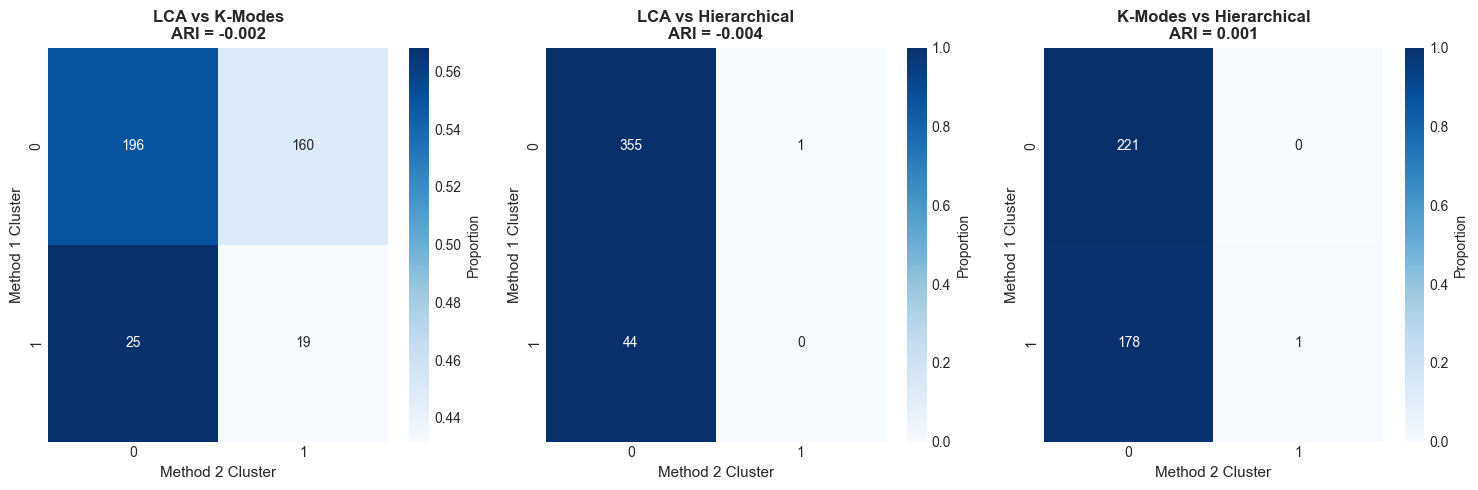


[INTERPRETATION]
These matrices show how clusters from different methods correspond.
- Diagonal dominance indicates strong agreement
- Off-diagonal values indicate disagreement
- Numbers show actual counts; colors show proportions


In [22]:
# =============================================================================
# VISUALIZE METHOD AGREEMENT
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create confusion matrices
from sklearn.metrics import confusion_matrix

methods = [
    ('LCA vs K-Modes', lca_labels, kmodes_labels, ari_lca_kmodes),
    ('LCA vs Hierarchical', lca_labels, hier_labels, ari_lca_hier),
    ('K-Modes vs Hierarchical', kmodes_labels, hier_labels, ari_kmodes_hier)
]

for ax, (title, labels1, labels2, ari) in zip(axes, methods):
    # Note: confusion matrix may need reordering for better visualization
    cm = confusion_matrix(labels1, labels2)
    
    # Normalize by row
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Proportion'})
    ax.set_title(f'{title}\nARI = {ari:.3f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Method 2 Cluster', fontsize=11)
    ax.set_ylabel('Method 1 Cluster', fontsize=11)

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("These matrices show how clusters from different methods correspond.")
print("- Diagonal dominance indicates strong agreement")
print("- Off-diagonal values indicate disagreement")
print("- Numbers show actual counts; colors show proportions")

In [23]:
# =============================================================================
# SELECT FINAL CLUSTERING (LCA as Gold Standard)
# =============================================================================

print("FINAL MODEL SELECTION")
print("=" * 60)
print("\nBased on the analysis, we select LCA as the primary clustering method.")
print("\nRationale:")
print("1. LCA provides probabilistic class memberships (uncertainty quantification)")
print("2. LCA has formal model selection criteria (BIC/AIC)")
print("3. LCA provides interpretable item response probabilities")
print("4. LCA is the statistically appropriate method for categorical survey data")

# Use LCA labels as final clustering
final_labels = lca_labels
final_model = optimal_lca

print(f"\nFinal Clustering: {optimal_k} classes identified")

FINAL MODEL SELECTION

Based on the analysis, we select LCA as the primary clustering method.

Rationale:
1. LCA provides probabilistic class memberships (uncertainty quantification)
2. LCA has formal model selection criteria (BIC/AIC)
3. LCA provides interpretable item response probabilities
4. LCA is the statistically appropriate method for categorical survey data

Final Clustering: 2 classes identified


---

## 5. Cluster Profiling - "The Faces of Poverty"

Now we characterize each cluster to understand the distinct **types of poverty** represented.

### 5.1 Item Response Probabilities

For each cluster $k$ and indicator $d$, we compute:

$$P(x_d = 1 | C_k)$$

This tells us the probability that a household in cluster $k$ is deprived in indicator $d$.

### 5.2 Relative Risk Ratios

$$RR_{kd} = \frac{P(x_d=1 | C_k)}{P(x_d=1 | \text{Population})}$$

**Interpretation:**
- **RR > 1**: Cluster $k$ has **HIGHER** deprivation rate than population average
- **RR < 1**: Cluster $k$ has **LOWER** deprivation rate than population average
- **RR = 1**: Same as population average
- **RR > 1.5**: Substantially elevated risk (1.5x the population rate)

In [24]:
# =============================================================================
# CALCULATE CLUSTER PROFILES
# =============================================================================

from utils.cluster_profiling import (
    calculate_item_response_probabilities,
    calculate_relative_risk_ratios,
    generate_cluster_profiles
)

# Generate comprehensive profiles
feature_names = list(df_analysis.columns)
profiles = generate_cluster_profiles(X, final_labels, feature_names, rr_threshold=1.5)

print("CLUSTER PROFILES GENERATED")
print("=" * 60)

# Display cluster sizes
print("\nCluster Sizes and Proportions:")
print("-" * 40)
for cluster, size in profiles['cluster_sizes'].items():
    prop = profiles['cluster_proportions'][cluster] * 100
    print(f"{cluster}: {size:,} households ({prop:.1f}%)")

CLUSTER PROFILES GENERATED

Cluster Sizes and Proportions:
----------------------------------------
Cluster 0: 356 households (89.0%)
Cluster 1: 44 households (11.0%)


In [25]:
# =============================================================================
# ITEM RESPONSE PROBABILITIES TABLE
# =============================================================================

print("ITEM RESPONSE PROBABILITIES: P(Deprived | Cluster)")
print("=" * 60)
print("\nThis shows the probability of being deprived in each indicator")
print("for each cluster. Higher values = more deprivation in that cluster.\n")

irp = profiles['item_response_probs']

# Style the dataframe
styled_irp = irp.style.background_gradient(cmap='RdYlGn_r', axis=None, vmin=0, vmax=1)
styled_irp = styled_irp.format('{:.2%}')

display(styled_irp)

ITEM RESPONSE PROBABILITIES: P(Deprived | Cluster)

This shows the probability of being deprived in each indicator
for each cluster. Higher values = more deprivation in that cluster.



,BLB,PendapatanbulananpurataisirumahkurangdaripadaPGK,Keadaantempattinggalusangataumulaiburuk,Lebih2ahliisirumahbilik,Menggunakantandasselaindaripadatandaspam,TiadakemudahanKutipanSampah,Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian,Isirumahtidakmampumenyewadanmemilikirumah,Tidakmemilikitelefontaliantetapatautelefonbimbit,Tidakdapatmengaksesinternet,TidakmendapatkemudahanawamTeknologiICT,Semuaahliisirumahberumur1760tahunmempunyaikurangdaripada11tahunp,Kanakkanakantara616tahunyangtidakbersekolah,Pemeliharaanagama,Pemeliharaanakal,Pemeliharaannyawa,Pemeliharaanketurunan,Pemeliharaanharta,Pengambilanmakanankurangdaripadatiga3kalisehari,Selaindaripadabekalanairterawatdidalamrumahdanpaipairawampaipber
Cluster 0,48.03%,75.00%,49.44%,90.17%,36.80%,20.22%,5.62%,10.96%,2.25%,23.60%,81.46%,0.00%,8.43%,0.56%,20.79%,0.84%,3.93%,7.02%,18.54%,4.21%
Cluster 1,65.91%,72.73%,75.00%,84.09%,40.91%,18.18%,2.27%,4.55%,4.55%,36.36%,70.45%,0.00%,4.55%,25.00%,63.64%,100.00%,27.27%,52.27%,27.27%,6.82%


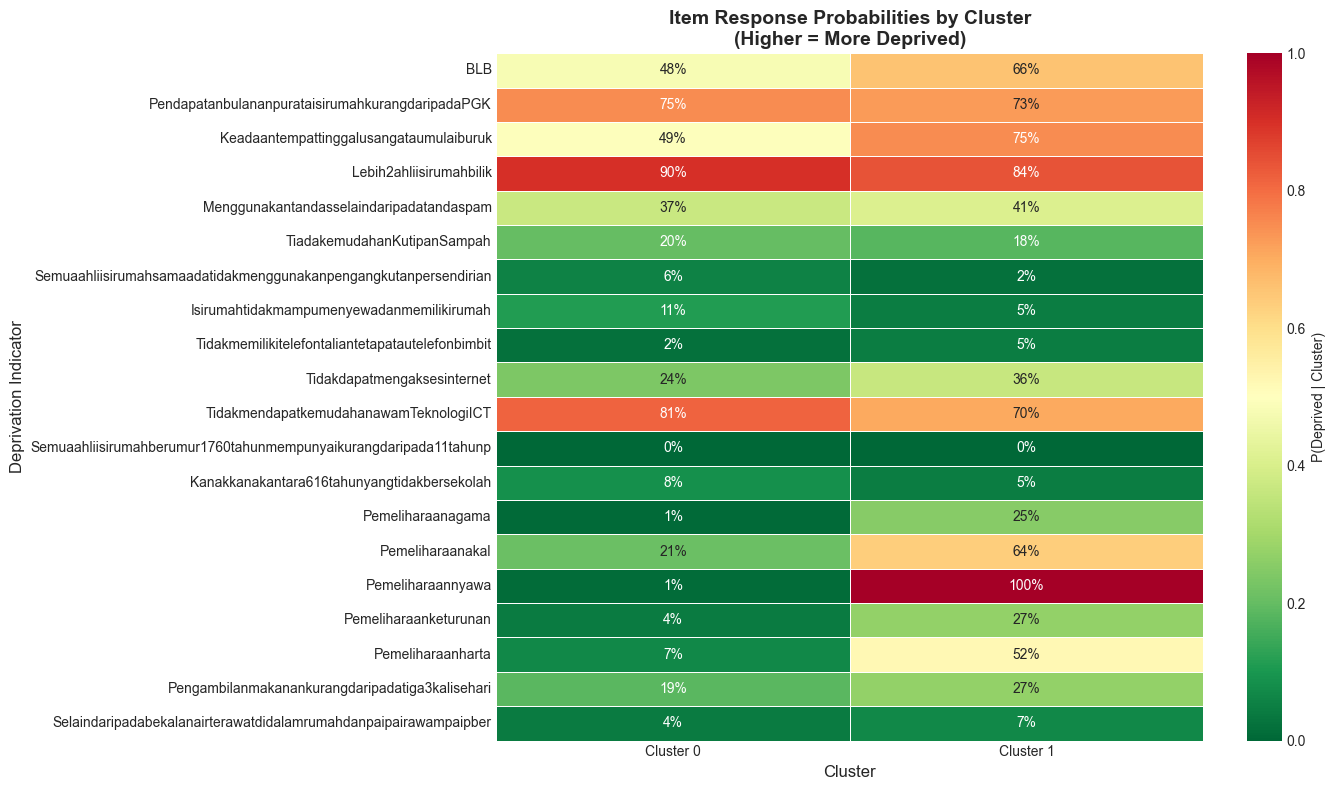


[INTERPRETATION]
- DARK RED: High deprivation probability (>70%)
- YELLOW: Moderate deprivation probability (30-70%)
- DARK GREEN: Low deprivation probability (<30%)

Look for patterns: which clusters have uniformly high/low deprivation?


In [26]:
# =============================================================================
# VISUALIZE ITEM RESPONSE PROBABILITIES HEATMAP
# =============================================================================

fig, ax = plt.subplots(figsize=(14, max(8, len(feature_names) * 0.4)))

# Transpose for better visualization (features as rows)
irp_plot = irp.T

sns.heatmap(irp_plot, annot=True, fmt='.0%', cmap='RdYlGn_r',
            cbar_kws={'label': 'P(Deprived | Cluster)'}, ax=ax,
            linewidths=0.5, vmin=0, vmax=1)

ax.set_title('Item Response Probabilities by Cluster\n(Higher = More Deprived)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Deprivation Indicator', fontsize=12)

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("- DARK RED: High deprivation probability (>70%)")
print("- YELLOW: Moderate deprivation probability (30-70%)")
print("- DARK GREEN: Low deprivation probability (<30%)")
print("\nLook for patterns: which clusters have uniformly high/low deprivation?")

In [27]:
# =============================================================================
# RELATIVE RISK RATIOS TABLE
# =============================================================================

print("RELATIVE RISK RATIOS: RR = P(Deprived|Cluster) / P(Deprived|Population)")
print("=" * 60)
print("\nRR > 1: HIGHER risk than population | RR < 1: LOWER risk than population")
print("RR > 1.5: Substantially elevated risk | RR < 0.67: Substantially lower risk\n")

rr = profiles['relative_risks']

# Custom color function for RR
def color_rr(val):
    if val > 1.5:
        return 'background-color: #e74c3c; color: white'  # High risk - red
    elif val > 1.0:
        return 'background-color: #f39c12'  # Elevated - orange
    elif val > 0.67:
        return 'background-color: #f1c40f'  # Near average - yellow
    else:
        return 'background-color: #2ecc71'  # Low risk - green

styled_rr = rr.style.applymap(color_rr).format('{:.2f}')
display(styled_rr)

RELATIVE RISK RATIOS: RR = P(Deprived|Cluster) / P(Deprived|Population)

RR > 1: HIGHER risk than population | RR < 1: LOWER risk than population
RR > 1.5: Substantially elevated risk | RR < 0.67: Substantially lower risk



,BLB,PendapatanbulananpurataisirumahkurangdaripadaPGK,Keadaantempattinggalusangataumulaiburuk,Lebih2ahliisirumahbilik,Menggunakantandasselaindaripadatandaspam,TiadakemudahanKutipanSampah,Semuaahliisirumahsamaadatidakmenggunakanpengangkutanpersendirian,Isirumahtidakmampumenyewadanmemilikirumah,Tidakmemilikitelefontaliantetapatautelefonbimbit,Tidakdapatmengaksesinternet,TidakmendapatkemudahanawamTeknologiICT,Semuaahliisirumahberumur1760tahunmempunyaikurangdaripada11tahunp,Kanakkanakantara616tahunyangtidakbersekolah,Pemeliharaanagama,Pemeliharaanakal,Pemeliharaannyawa,Pemeliharaanketurunan,Pemeliharaanharta,Pengambilanmakanankurangdaripadatiga3kalisehari,Selaindaripadabekalanairterawatdidalamrumahdanpaipairawampaipber
Cluster 0,0.96,1.00,0.95,1.01,0.99,1.01,1.07,1.07,0.90,0.94,1.02,0.00,1.05,0.17,0.82,0.07,0.61,0.59,0.95,0.94
Cluster 1,1.32,0.97,1.44,0.94,1.10,0.91,0.43,0.44,1.82,1.45,0.88,0.00,0.57,7.69,2.50,8.51,4.20,4.36,1.40,1.52


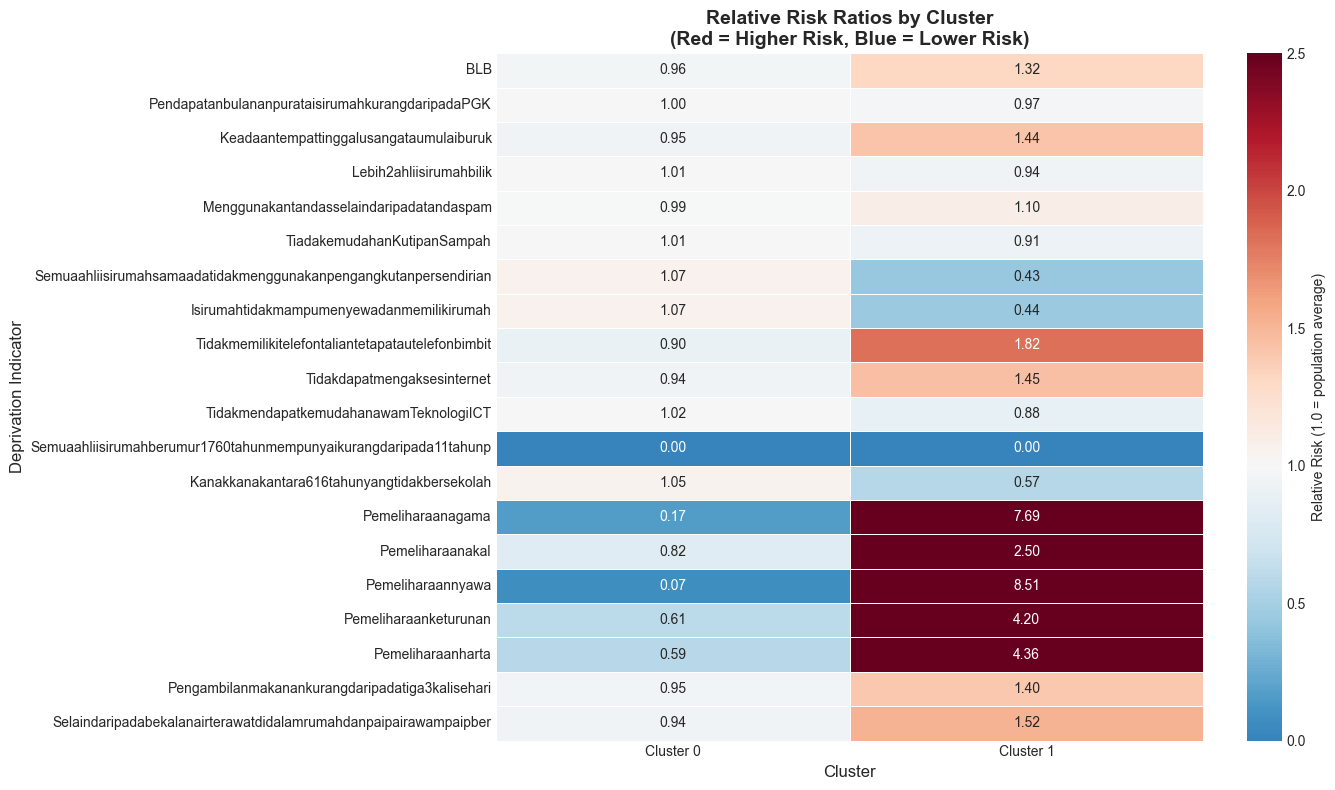


[INTERPRETATION]
- DARK RED: Much higher risk than population (RR > 1.5)
- LIGHT RED: Slightly elevated risk (RR 1.0-1.5)
- WHITE: Same as population average (RR = 1.0)
- LIGHT BLUE: Lower risk (RR 0.5-1.0)
- DARK BLUE: Much lower risk (RR < 0.5)


In [28]:
# =============================================================================
# VISUALIZE RELATIVE RISK HEATMAP
# =============================================================================

fig, ax = plt.subplots(figsize=(14, max(8, len(feature_names) * 0.4)))

# Transpose for better visualization
rr_plot = rr.T

# Use diverging colormap centered at 1.0
sns.heatmap(rr_plot, annot=True, fmt='.2f', cmap='RdBu_r',
            center=1.0, vmin=0, vmax=2.5,
            cbar_kws={'label': 'Relative Risk (1.0 = population average)'}, 
            ax=ax, linewidths=0.5)

ax.set_title('Relative Risk Ratios by Cluster\n(Red = Higher Risk, Blue = Lower Risk)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Deprivation Indicator', fontsize=12)

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("- DARK RED: Much higher risk than population (RR > 1.5)")
print("- LIGHT RED: Slightly elevated risk (RR 1.0-1.5)")
print("- WHITE: Same as population average (RR = 1.0)")
print("- LIGHT BLUE: Lower risk (RR 0.5-1.0)")
print("- DARK BLUE: Much lower risk (RR < 0.5)")

In [29]:
# =============================================================================
# CLUSTER DESCRIPTIONS - "THE FACES OF POVERTY"
# =============================================================================

print("\n" + "=" * 70)
print("THE FACES OF POVERTY: Cluster Archetypes")
print("=" * 70)

for cluster, description in profiles['cluster_descriptions'].items():
    size = profiles['cluster_sizes'][cluster]
    prop = profiles['cluster_proportions'][cluster] * 100
    
    print(f"\n{cluster.upper()} ({size:,} households, {prop:.1f}%)")
    print("-" * 60)
    print(f"Profile: {description}")
    
    # Show top high-risk indicators
    high_risk = profiles['high_risk_features'].get(cluster, {})
    if high_risk:
        print(f"\nHigh-Risk Indicators (RR > 1.5):")
        for indicator, rr_val in list(high_risk.items())[:5]:
            print(f"  - {indicator}: {rr_val:.2f}x population rate")
    
    # Show low-risk indicators
    low_risk = profiles['low_risk_features'].get(cluster, {})
    if low_risk:
        print(f"\nLow-Risk Indicators (RR < 0.67):")
        for indicator, rr_val in list(low_risk.items())[:5]:
            print(f"  - {indicator}: {rr_val:.2f}x population rate")


THE FACES OF POVERTY: Cluster Archetypes

CLUSTER 0 (356 households, 89.0%)
------------------------------------------------------------
Profile: Moderate: (89.0% of population) Near-average deprivation levels. Protected from: Semuaahliisirumahberumur1760tahunmempunyaikurangdaripada11tahunp, Pemeliharaannyawa, Pemeliharaanagama.

Low-Risk Indicators (RR < 0.67):
  - Semuaahliisirumahberumur1760tahunmempunyaikurangdaripada11tahunp: 0.00x population rate
  - Pemeliharaannyawa: 0.07x population rate
  - Pemeliharaanagama: 0.17x population rate
  - Pemeliharaanharta: 0.59x population rate
  - Pemeliharaanketurunan: 0.61x population rate

CLUSTER 1 (44 households, 11.0%)
------------------------------------------------------------
Profile: Mixed Profile: (11.0% of population) Mixed deprivation pattern. High risk in: Pemeliharaannyawa, Pemeliharaanagama, Pemeliharaanharta. Protected from: Semuaahliisirumahberumur1760tahunmempunyaikurangdaripada11tahunp, Semuaahliisirumahsamaadatidakmengguna

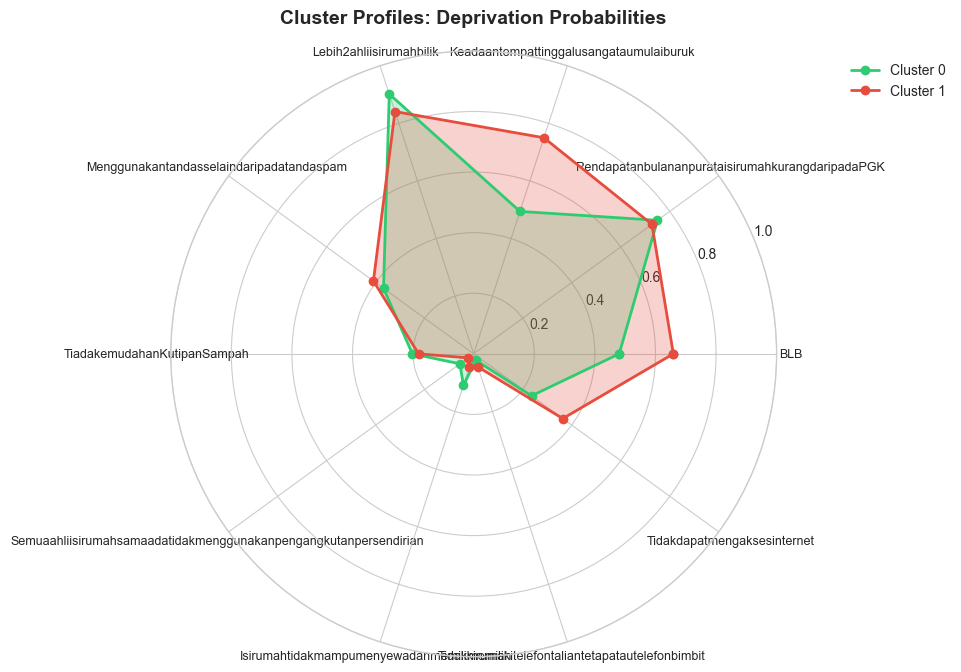


[INTERPRETATION]
This radar chart shows each cluster's deprivation profile.
- Points further from center = higher deprivation probability
- Overlapping areas show shared deprivation patterns
- Non-overlapping areas show distinguishing features


In [30]:
# =============================================================================
# RADAR CHART - CLUSTER PROFILES COMPARISON
# =============================================================================

from math import pi

# Select top indicators for visualization (limit to 10 for readability)
n_indicators = min(10, len(feature_names))
selected_features = feature_names[:n_indicators]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Number of variables
categories = selected_features
N = len(categories)

# Angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Plot each cluster
for i, cluster in enumerate(irp.index):
    values = irp.loc[cluster, selected_features].values.tolist()
    values += values[:1]  # Close the loop
    
    ax.plot(angles, values, 'o-', linewidth=2, label=cluster, color=COLORS[i % len(COLORS)])
    ax.fill(angles, values, alpha=0.25, color=COLORS[i % len(COLORS)])

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9)
ax.set_ylim(0, 1)

ax.set_title('Cluster Profiles: Deprivation Probabilities', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("This radar chart shows each cluster's deprivation profile.")
print("- Points further from center = higher deprivation probability")
print("- Overlapping areas show shared deprivation patterns")
print("- Non-overlapping areas show distinguishing features")

---

## 6. Validation Framework

To ensure the results are **publishable and robust**, we perform comprehensive validation.

### 6.1 Bootstrap Stability Analysis

We resample the dataset many times and measure the **Adjusted Rand Index (ARI)** between the original clusters and the bootstrap clusters.

**Interpretation of ARI:**
- **ARI = 1.0**: Perfect agreement (identical clusterings)
- **ARI > 0.9**: Excellent stability
- **ARI > 0.7**: Good stability
- **ARI > 0.5**: Fair stability
- **ARI < 0.5**: Poor stability (results may not be reliable)

**Threshold:** Stable clusters should have **ARI > 0.7** across bootstrap samples.

In [31]:
# =============================================================================
# BOOTSTRAP STABILITY ANALYSIS
# =============================================================================

from utils.validation import bootstrap_stability_analysis

print("BOOTSTRAP STABILITY ANALYSIS")
print("=" * 60)
print("\nResampling the dataset 100 times to assess cluster stability...")
print("(This may take a few minutes)\n")

# Define clustering function for bootstrap
def lca_clustering_func(X_sample):
    model = LatentClassModel()
    model.set_params(n_classes=optimal_k, max_iter=50, n_init=3, random_state=42)
    return model.fit_predict(X_sample)

# Run bootstrap analysis
stability_results = bootstrap_stability_analysis(
    X,
    lca_clustering_func,
    n_bootstrap=100,
    sample_ratio=0.8,
    random_state=42
)

print("\nBOOTSTRAP STABILITY RESULTS")
print("-" * 40)
print(f"Mean ARI:   {stability_results['mean_ari']:.3f}")
print(f"Std ARI:    {stability_results['std_ari']:.3f}")
print(f"Median ARI: {stability_results['median_ari']:.3f}")
print(f"Min ARI:    {stability_results['min_ari']:.3f}")
print(f"Max ARI:    {stability_results['max_ari']:.3f}")
print(f"\nStability Grade: {stability_results['stability_grade']}")
print(f"Is Stable (ARI > 0.7): {stability_results['is_stable']}")

BOOTSTRAP STABILITY ANALYSIS

Resampling the dataset 100 times to assess cluster stability...
(This may take a few minutes)


BOOTSTRAP STABILITY RESULTS
----------------------------------------
Mean ARI:   0.578
Std ARI:    0.364
Median ARI: 0.693
Min ARI:    -0.079
Max ARI:    1.000

Stability Grade: Fair
Is Stable (ARI > 0.7): False


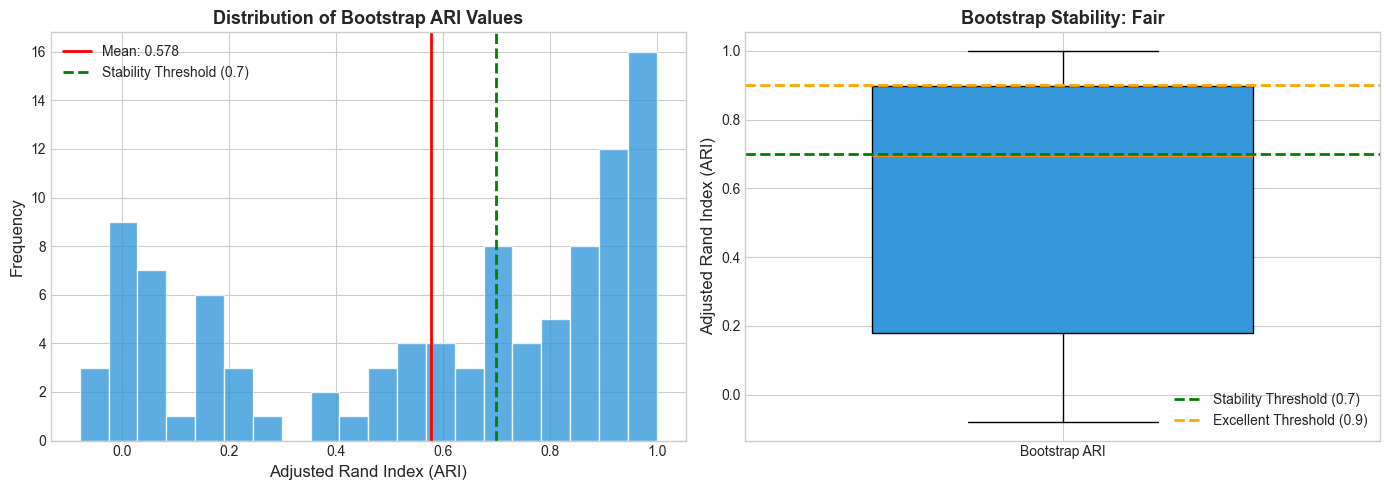


[INTERPRETATION]
- GREEN LINE: Stability threshold (ARI = 0.7). Values above this indicate stable clusters.
- ORANGE LINE: Excellent stability threshold (ARI = 0.9).
- Tight distribution (low variance) indicates more reliable results.

Your clusters have fair stability.


In [32]:
# =============================================================================
# VISUALIZE BOOTSTRAP STABILITY
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of ARI values
ax1 = axes[0]
ari_values = stability_results['ari_values']
ax1.hist(ari_values, bins=20, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(x=stability_results['mean_ari'], color='red', linestyle='-', linewidth=2, label=f"Mean: {stability_results['mean_ari']:.3f}")
ax1.axvline(x=0.7, color='green', linestyle='--', linewidth=2, label='Stability Threshold (0.7)')
ax1.set_xlabel('Adjusted Rand Index (ARI)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Bootstrap ARI Values', fontsize=13, fontweight='bold')
ax1.legend()

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(ari_values, patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('#3498db')
ax2.axhline(y=0.7, color='green', linestyle='--', linewidth=2, label='Stability Threshold (0.7)')
ax2.axhline(y=0.9, color='orange', linestyle='--', linewidth=2, label='Excellent Threshold (0.9)')
ax2.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12)
ax2.set_title(f'Bootstrap Stability: {stability_results["stability_grade"]}', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Bootstrap ARI'])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("- GREEN LINE: Stability threshold (ARI = 0.7). Values above this indicate stable clusters.")
print("- ORANGE LINE: Excellent stability threshold (ARI = 0.9).")
print("- Tight distribution (low variance) indicates more reliable results.")
print(f"\nYour clusters have {stability_results['stability_grade'].lower()} stability.")

### 6.2 External Validation

We validate the clusters by cross-tabulating with known external variables. If the clusters have semantic meaning, they should show meaningful associations with external variables.

**For example:**
- If there's an "Infrastructurally Deprived" cluster, it should be predominantly rural
- If there's an "Income Poor Only" cluster, it should show different geographic patterns

**Statistical Tests:**
- **Chi-Square Test**: Tests for association between clusters and external variable
- **Cramer's V**: Effect size (0 = no association, 1 = perfect association)

In [33]:
# =============================================================================
# EXTERNAL VALIDATION (if external variable available)
# =============================================================================

from utils.validation import external_validation

print("EXTERNAL VALIDATION")
print("=" * 60)

# Look for potential external validation variables (e.g., urban/rural)
potential_external_vars = ['Bandar', 'Strata', 'State', 'Region', 'Area', 'Locality']
external_var_found = None

for var in potential_external_vars:
    matching_cols = [c for c in df.columns if var.lower() in c.lower()]
    if matching_cols:
        external_var_found = matching_cols[0]
        break

if external_var_found:
    print(f"\nUsing external variable: {external_var_found}")
    
    # Get external variable values (aligned with analysis data)
    external_values = df.loc[df_analysis.index, external_var_found].values
    
    # Perform validation
    ext_results = external_validation(final_labels, external_values, external_var_found)
    
    print("\nCross-tabulation (row percentages):")
    print(ext_results['crosstab_pct'])
    
    print(f"\nChi-square statistic: {ext_results['chi_square']:.2f}")
    print(f"P-value: {ext_results['p_value']:.4e}")
    print(f"Cramer's V (effect size): {ext_results['cramers_v']:.3f}")
    print(f"Normalized Mutual Information: {ext_results['nmi']:.3f}")
    
    print("\n[INTERPRETATION]")
    if ext_results['p_value'] < 0.05:
        print(f"SIGNIFICANT association found (p < 0.05).")
        print(f"The clusters are meaningfully related to {external_var_found}.")
    else:
        print(f"No significant association found (p >= 0.05).")
    
    print(f"\nCramer's V interpretation:")
    print(f"  0.0-0.1: Negligible | 0.1-0.3: Weak | 0.3-0.5: Moderate | >0.5: Strong")
else:
    print("\nNo suitable external validation variable found in the dataset.")
    print("Consider adding urban/rural or geographic variables for validation.")

EXTERNAL VALIDATION

No suitable external validation variable found in the dataset.
Consider adding urban/rural or geographic variables for validation.


In [34]:
# =============================================================================
# COMPREHENSIVE VALIDATION SUMMARY
# =============================================================================

from utils.validation import comprehensive_validation

print("\n" + "=" * 70)
print("COMPREHENSIVE VALIDATION SUMMARY")
print("=" * 70)

# Prepare external variable if available
ext_var = df.loc[df_analysis.index, external_var_found].values if external_var_found else None

validation_results = comprehensive_validation(
    X, final_labels,
    clustering_func=lca_clustering_func,
    external_var=ext_var,
    external_name=external_var_found if external_var_found else 'External',
    n_bootstrap=50  # Fewer for speed
)

print(f"\nNumber of Clusters: {validation_results['n_clusters']}")
print(f"\nCluster Sizes: {validation_results['cluster_sizes']}")
print(f"\nSilhouette Score: {validation_results['silhouette']:.3f}")
print("  (Higher is better. Range: -1 to 1. >0.5 is good, >0.7 is excellent)")
print(f"\nDavies-Bouldin Index: {validation_results['davies_bouldin']:.3f}")
print("  (Lower is better. Measures cluster separation vs. compactness)")
print(f"\nSummary: {validation_results['summary']}")


COMPREHENSIVE VALIDATION SUMMARY

Number of Clusters: 2

Cluster Sizes: {np.int64(0): np.int64(356), np.int64(1): np.int64(44)}

Silhouette Score: 0.181
  (Higher is better. Range: -1 to 1. >0.5 is good, >0.7 is excellent)

Davies-Bouldin Index: 2.455
  (Lower is better. Measures cluster separation vs. compactness)

Summary: Weak cluster structure (Silhouette: 0.181) | Stability: Fair (ARI: 0.624)


---

## 7. Conclusions & Policy Implications

### Summary of Findings

This analysis has identified distinct **types of poverty** in the population using rigorous methodology appropriate for binary deprivation data.

In [35]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("=" * 70)
print("FINAL ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n1. DATA OVERVIEW")
print(f"   - {len(df_analysis):,} households analyzed")
print(f"   - {len(deprivation_cols)} deprivation indicators")

print(f"\n2. METHODOLOGY")
print(f"   - Tetrachoric correlation for binary variable relationships")
print(f"   - MCA for dimensionality reduction (not PCA)")
print(f"   - LCA for probabilistic clustering (not K-Means)")
print(f"   - Jaccard distance for distance-based methods")

print(f"\n3. OPTIMAL CLUSTERING")
print(f"   - Number of clusters: {optimal_k}")
print(f"   - Selection criterion: BIC (lower is better)")
print(f"   - Stability: {stability_results['stability_grade']} (ARI = {stability_results['mean_ari']:.3f})")

print(f"\n4. CLUSTER PROFILES (Faces of Poverty)")
for cluster, desc in profiles['cluster_descriptions'].items():
    size = profiles['cluster_sizes'][cluster]
    prop = profiles['cluster_proportions'][cluster] * 100
    print(f"   - {cluster}: {prop:.1f}% of population")

print(f"\n5. VALIDATION")
print(f"   - Bootstrap Stability: {stability_results['stability_grade']}")
print(f"   - Silhouette Score: {validation_results['silhouette']:.3f}")

print(f"\n6. POLICY IMPLICATIONS")
print(f"   The identified clusters represent distinct TYPES of poverty that")
print(f"   may require different intervention strategies:")
print(f"   - Target 'Deeply Deprived' clusters with comprehensive programs")
print(f"   - Address specific deprivation patterns in specialized clusters")
print(f"   - Use cluster membership for efficient resource allocation")

FINAL ANALYSIS SUMMARY

1. DATA OVERVIEW
   - 400 households analyzed
   - 20 deprivation indicators

2. METHODOLOGY
   - Tetrachoric correlation for binary variable relationships
   - MCA for dimensionality reduction (not PCA)
   - LCA for probabilistic clustering (not K-Means)
   - Jaccard distance for distance-based methods

3. OPTIMAL CLUSTERING
   - Number of clusters: 2
   - Selection criterion: BIC (lower is better)
   - Stability: Fair (ARI = 0.578)

4. CLUSTER PROFILES (Faces of Poverty)
   - Cluster 0: 89.0% of population
   - Cluster 1: 11.0% of population

5. VALIDATION
   - Bootstrap Stability: Fair
   - Silhouette Score: 0.181

6. POLICY IMPLICATIONS
   The identified clusters represent distinct TYPES of poverty that
   may require different intervention strategies:
   - Target 'Deeply Deprived' clusters with comprehensive programs
   - Address specific deprivation patterns in specialized clusters
   - Use cluster membership for efficient resource allocation


In [36]:
# =============================================================================
# EXPORT RESULTS
# =============================================================================

print("\nEXPORTING RESULTS")
print("=" * 60)

# Add cluster labels to original data
df_with_clusters = df_analysis.copy()
df_with_clusters['Cluster'] = final_labels
df_with_clusters['Cluster_Name'] = ['Cluster_' + str(l) for l in final_labels]

# Save to CSV
output_file = 'MPI_Clustering_Results.csv'
df_with_clusters.to_csv(output_file, index=True)
print(f"\nCluster assignments saved to: {output_file}")

# Save profiles
profiles['item_response_probs'].to_csv('Cluster_Item_Response_Probabilities.csv')
profiles['relative_risks'].to_csv('Cluster_Relative_Risk_Ratios.csv')
print("Cluster profiles saved to CSV files.")

print("\nAnalysis complete!")


EXPORTING RESULTS

Cluster assignments saved to: MPI_Clustering_Results.csv
Cluster profiles saved to CSV files.

Analysis complete!


---

## Appendix: Method Reference

### Interpretation Guide Summary

| Metric | Range | Interpretation | Goal |
|--------|-------|----------------|------|
| **BIC** | -inf to +inf | Model fit with complexity penalty | **LOWER** is better |
| **AIC** | -inf to +inf | Model fit with less penalty | **LOWER** is better |
| **Entropy** | 0 to 1 | Classification certainty | **HIGHER** is better (>0.8 good) |
| **ARI** | -1 to 1 | Cluster agreement/stability | **HIGHER** is better (>0.7 stable) |
| **Silhouette** | -1 to 1 | Cluster separation | **HIGHER** is better (>0.5 good) |
| **Davies-Bouldin** | 0 to +inf | Cluster quality | **LOWER** is better |
| **Relative Risk** | 0 to +inf | Elevated/reduced risk | >1.5 = high risk, <0.67 = low risk |
| **Tetrachoric r** | -1 to 1 | Binary variable correlation | >0.9 suggests redundancy |
| **Cramer's V** | 0 to 1 | Association strength | >0.3 moderate, >0.5 strong |

---

*This notebook was designed following PhD-level statistical methodology for categorical data clustering.*